# SIFT特征提取实验

## 实验目的
从不同视角对教学楼对教学楼拍摄一对图像（保证图像间有一定重叠区域）：

| ![1](building_1.jpg) | ![2](building_2.jpg) |
|:-:|:-:|

试编程实现完整的SIFT特征检测与匹配算法，并在上述图像对上进行算法测试。



## 实验环境
- OpenCV2
- MatPlotLib

## 实验原理

### SIFT 特征点

#### 高斯差分与金字塔

在SIFT（Scale-Invariant Feature Transform）算法中，为了实现尺度不变性，首先要构建图像的尺度不变性尺度空间。给定一张图像$I(x, y)$，其尺度空间可以表示为

$$
L(x, y, \sigma) = K(x, y, \sigma) * I(x, y)
$$

其中，$K(x, y, \sigma)$是尺度为$\sigma$的卷积核。

研究发现，高斯拉普拉斯尺度空间具有尺度不变性，而高斯差分尺度空间是其良好的近似，且计算简单，高斯差分核定义为：

$$
DoG(x, y, \sigma) = G(x, y, k\sigma) - G(x, y, \sigma)
$$

其中，$G(x, y, \sigma)$是尺度为$\sigma$的高斯核，$k$是一个常数（通常取$k = \sqrt{2}$）。先求出高斯核的尺度空间$L(x, y, \sigma)$，高斯差分尺度空间$D(x, y, \sigma)$可以表示为：

$$
D(x, y, \sigma) = L(x, y, k\sigma) - L(x, y, \sigma)
$$

通过对图像进行多层次的模糊处理并计算其高斯差分图，可以构建出尺度空间金字塔，每层金字塔中的图像包含相应尺度的特征信息。

#### 关键点定位

关键点是通过检测高斯差分尺度空间的局部极值点得到的。

在定位关键点时，每个像素需要与其26邻域中的所有像素进行比较，26邻域包括当前尺度层的8个邻域像素，以及上一层和下一层的各9个邻域像素。如果一个像素点在其26邻域中同时具有最大或最小的DoG值，则认为它是一个潜在的关键点。

为了进一步精确定位关键点的位置，SIFT使用泰勒级数展开来近似关键点在尺度空间中的位置。将DoG函数在当前点$(x, y, \sigma)$附近进行二阶泰勒展开得到：

$$
D(x) \approx D + \frac{\partial D}{\partial x} x + \frac{1}{2} x^T \frac{\partial^2 D}{\partial x^2} x
$$

其中，$x = (x, y, \sigma)^T$是位置的偏移向量，$\frac{\partial D}{\partial x}$是DoG在当前点的梯度向量，$\frac{\partial^2 D}{\partial x^2}$是Hessian矩阵。通过拟合并求解上述公式的极值，可以得到关键点的亚像素位置。

#### 不稳定点剔除

在实际应用中，许多检测到的极值点是由噪声或边缘引起的，而非稳定的特征点。

在 SIFT 算法中，为了剔除对比度较低的点，采用了一个简单的阈值判断方法。计算每个潜在关键点的 DoG 值 $D(x)$ 并与设定的阈值 $T_c$（通常$T_c=0.03$）进行比较。如果 $|D(x)| < T_c$，则认为该关键点为低对比度点，不具有显著的特征信息，可以直接将其舍弃。

为了剔除边缘点，SIFT使用一个主曲率比值的判别方法。首先，通过Hessian矩阵的特征值来确定主曲率方向，定义Hessian矩阵为：

$$
H = \begin{bmatrix} D_{xx} & D_{xy} \\ D_{xy} & D_{yy} \end{bmatrix}
$$

设Hessian矩阵的两个特征值为$\lambda_1$和$\lambda_2$，则主曲率比可以表示为：

$$
\frac{\lambda_1}{\lambda_2}
$$

通常设定一个阈值，如果主曲率比值过大，则认为该点是由边缘效应引起的，可以剔除掉。


#### SIFT描述子

SIFT描述子具有旋转和尺度不变性，可以在图像平移、旋转或缩放时保持相对稳定。生成描述子的步骤包括：

1. 主方向校正：每个关键点根据梯度方向和幅值被分配一个主方向，以实现旋转不变性；
2. 区域划分：在关键点的邻域内，将区域划分为`4x4`的小块（子区域），每个小块包含若干像素点；
3. 插值运算得到直方图：对每个小块中的像素计算其梯度方向，并将这些方向的强度值分布到8个方向的直方图中。这样每个小块形成一个8维的向量；
4. 形成特征向量：将16个小块的8维直方图组合起来，形成一个长度为128维的特征向量；
5. 归一化和阈值：归一化128维向量，以应对线性光照变化；将所有大于0.2的元素赋值为0.2，以应对非线性光照变化。

在OpenCV中，可以通过`cv2.SIFT_create()`来创建一个SIFT对象，主要参数有：
- `nOctaveLayers`：每组金字塔中的层数，通常取值为3。
- `contrastThreshold`：对比度阈值，用于过滤低对比度的关键点。
- `edgeThreshold`：边缘阈值，用于剔除边缘的响应。
- `sigma`：高斯模糊的标准差，用于控制尺度空间的初始模糊度。

在SIFT对象创建后，可以通过调用`detectAndCompute`方法来对图像进行关键点检测和描述符计算。该方法接收一个输入图像，并返回检测到的关键点和对应的描述符。

### 特征匹配
本实验采用暴力特征匹配 BFMatcher（Brute-Force Matcher）。主要思想是对每个特征点直接与所有其他特征点计算距离，并找到距离最近的匹配对。这种方法虽然效率较低，但在匹配准确性上较好，尤其适用于小规模的特征点匹配任务。它在计算上比较直接，即使用最简单的距离度量方法来进行特征匹配。

在OpenCV中，`cv2.BFMatcher`可以用于实现暴力匹配。主要参数有：
- `normType`：用于指定距离度量方法，如欧氏距离（`cv2.NORM_L2`）和汉明距离（`cv2.NORM_HAMMING`）。`cv2.NORM_L2`适用于SIFT、SURF等浮点型描述符；`cv2.NORM_HAMMING`适用于ORB、BRISK等二进制描述符。
- `crossCheck`：是否启用交叉验证匹配，默认为`False`。若启用交叉验证，则仅保留A图像的关键点a与B图像的关键点b匹配，且b也匹配回a的那些特征点，这样可以提高匹配的准确性。

主要方法有：
- `match()`：一对一匹配，将一个特征点与另一个特征点进行最近邻匹配。
- `knnMatch()`：k近邻匹配，为每个特征点找到k个最相似的匹配点（通常k=2）。

## 实验过程
将两幅图片分别提取SIFT特征点和描述子，然后进行特征匹配，将所有匹配以连线的形式画出。

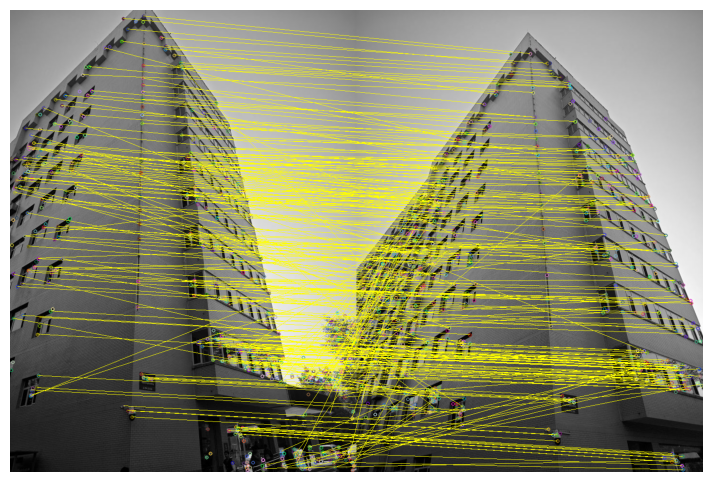

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 读取图像
img1 = cv2.imread('building_1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('building_2.jpg', cv2.IMREAD_GRAYSCALE)

# 初始化SIFT特征检测器
sift = cv2.SIFT_create(
    nOctaveLayers=3,
    contrastThreshold=0.08,
    edgeThreshold=5,
    sigma=1.6
)

# 检测SIFT特征并计算描述符
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# 使用暴力匹配器匹配特征点
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# 绘制特征点
img1_with_keypoints = cv2.drawKeypoints(img1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
img2_with_keypoints = cv2.drawKeypoints(img2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

# 合并两幅图像
h1, w1 = img1_with_keypoints.shape[:2]
h2, w2 = img2_with_keypoints.shape[:2]
img_with_keypoints = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
img_with_keypoints[:h1, :w1] = img1_with_keypoints
img_with_keypoints[:h2, w1:] = img2_with_keypoints

# 绘制连线
img_output = img_with_keypoints.copy()
for match in matches:
    pt1 = (int(keypoints1[match.queryIdx].pt[0]), int(keypoints1[match.queryIdx].pt[1]))
    pt2 = (int(keypoints2[match.trainIdx].pt[0] + w1), int(keypoints2[match.trainIdx].pt[1]))
    cv2.line(img_output, pt1, pt2, (255, 255, 0), 1) # yellow

plt.figure(figsize=(12, 6))
plt.imshow(img_output, cmap='gray')
plt.axis('off')
plt.show()

通过对图像进行特征点检测和匹配，我们可以观察到绝大多数特征点匹配都是正确的。这些正确匹配的特征点连线通常形成一组几乎平行的线条，表示出两幅图像中的相应区域在几何位置上的一致性。这一族平行连线显示了SIFT算法在特征点匹配中的准确性和鲁棒性。

然而，少量的错误匹配也不可避免地出现在匹配结果中。通常，这些错误匹配点表现为在两幅图像间的明显交叉连线。错误原因可能为：

1. 纹理重复：图像中很多出现相似或重复的纹理模式（如墙砖、窗户），可能会将这些模式误认为是对应的特征点，从而导致错误匹配；
2. 低对比度区域：在对比度较低的区域，特征点的描述信息不够显著，容易被误匹配。